# Шахвалиева Юлиана

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
import time

### Чтение входных данных

In [2]:
data = pd.read_csv('../data/data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


### Удаление ненужных колонок

In [3]:
useless_clmns = ['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1']
data = data.drop(useless_clmns, axis=1)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


### Анализ входных данных

In [6]:
# Функция для форматирования текста
def get_pretty_title(text):
    return ('\033[1m' + text + '\033[0m').center(55)

# Функция для форматирования вывода в консоль
def pretty_print(text, values):
    print(f'\n\n{get_pretty_title(text)}', values, sep='\n\n')

# Функция для анализа входных данных
def analysis(data: pd.DataFrame):  
    
    # Просмотр типов входных данных
    dtypes = data.dtypes
    pretty_print('Типы данных:', dtypes)
    
    # Подсчет описательных статистик для всех признаков
    statistics = data.describe()
    pretty_print('Описательные статистики:', statistics)
    
    # Поиск пропусков в данных
    nan_values = data.isna().sum()
    pretty_print('Пропуски в данных:', nan_values)
    
    # Подсчет количества дубликатов
    count_duplicates = data.duplicated().sum()
    pretty_print('Количество дубликатов:', count_duplicates)
    
    # Распределение целевой переменной по классам
    count_target_value = data['clicks'].value_counts()
    pretty_print('Распределение целевой переменной:', count_target_value) 
    
    # Корреляционный анализ
    features = list(data.columns)
    features.remove('date_time')
    
    print(f'\n\n{get_pretty_title("Корреляционная матрица")}')
    
    plt.figure(figsize=[6, 5])
    sns.heatmap(data[features].corr(), vmin=-1, vmax=1, center=0)
    plt.show()



                  Типы данных:                 

date_time          object
zone_id             int64
banner_id           int64
campaign_clicks     int64
os_id               int64
country_id          int64
impressions         int64
clicks              int64
dtype: object


            Описательные статистики:           

            zone_id     banner_id  campaign_clicks         os_id  \
count  1.582147e+07  1.582147e+07     1.582147e+07  1.582147e+07   
mean   8.152679e+01  3.816483e+02     6.238540e-01  1.840605e+00   
std    1.632448e+02  3.959386e+02     9.249152e+00  1.530005e+00   
min    0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   
25%    1.400000e+01  5.200000e+01     0.000000e+00  1.000000e+00   
50%    1.900000e+01  2.170000e+02     0.000000e+00  2.000000e+00   
75%    6.000000e+01  6.110000e+02     0.000000e+00  3.000000e+00   
max    3.443000e+03  1.632000e+03     8.290000e+02  1.000000e+01   

         country_id  impressions        clicks  
count  1.58214

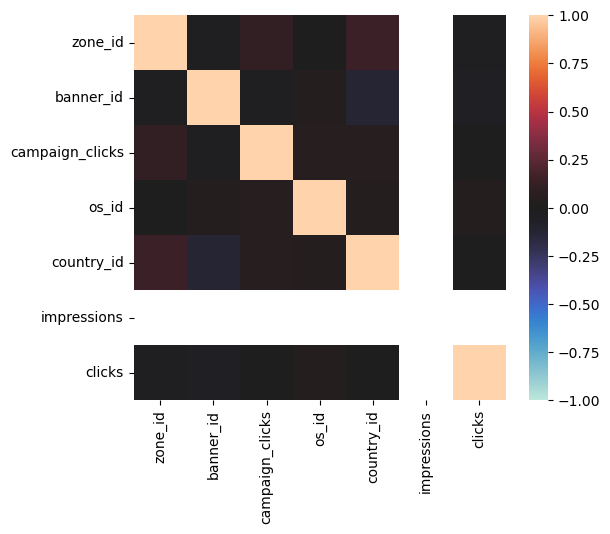

In [5]:
# Применение функции для анализа входных данных
analysis(data)

#### Выводы из проведенного анализа: 
+ Все признаки, кроме одного имеют целочисленный тип данных. Тип признака `data_time` при дальнейшем препроцессинге необходимо поменять;
+ Все признаки кроме `data_time`, `impressions`, `clicks` - категориальные. Для работы с ними необходимо будет применить процедуру one-hot encoding;
+ Признак `impressions` везде имеет значение `1`, поэтому перед построением модели его необходимо удалить;
+ Количество входнных данных: `15821472`;
+ В данных нет пропусков;
+ В данных присутствуют `620039` одинаковых записей, от них необходимо избавиться;
+ Целевая переменная распределена неравномерно, предсставителей одного класса сильно больше, чем представителей другого, это необходимо учитывать при построении модели;
+ Корреляционная матрица подтверждает необходимость удаления признака `impressions`, оставшиеся признаки имеют низкую корреляцию между собой, то есть их можно считать независимыми.

### Предобработка данных

In [4]:
# Функция для построения фичей и разделения выборки на тренировочную и тестовую части
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # Изменение типа признака date_time
    data['date_time'] = pd.to_datetime(data['date_time'])
    
    # Удаление признака impressions
    data = data.drop(['impressions'], axis=1)
    
    # Удаление дубликатов
    data = data.drop_duplicates()
    
    # Создание фичей на основе признака date_time: категориальный признак, отвечающий за день недели 
    # и категориальный признак, отвечающий за время суток: утро, день, вечер, ночь
    data['day'] = data['date_time'].dt.dayofweek
    data['time'] = pd.cut(data['date_time'].dt.hour, bins=[0, 7, 12, 18, 24], labels=[0, 1, 2, 3])
    
    # One-hot encoding категориальных признаков
    columns_to_encode = ['zone_id', 'banner_id', 'campaign_clicks', 'os_id', 'country_id', 'day', 'time']
    encoder = OneHotEncoder(drop='first', sparse_output=True)
    encoded_features = encoder.fit(data[columns_to_encode])
    
    # Разделение выборки на тестовую и тренировочную часть: в тестовую попали наблюдения из последнего дня   
    last_day = data['date_time'].dt.date.max()
    
    data_train = data[data['date_time'].dt.date < last_day]
    data_test = data[data['date_time'].dt.date >= last_day]
    
    y_train = data_train.clicks
    X_train = data_train.drop(['clicks', 'date_time'], axis=1)
    
    y_test = data_test.clicks
    X_test = data_test.drop(['clicks', 'date_time'], axis=1)
    
    X_train_encoded = encoder.transform(X_train[columns_to_encode])
    X_train = hstack([X_train.drop(columns=columns_to_encode).values, X_train_encoded])
    
    X_test_encoded = encoder.transform(X_test[columns_to_encode])
    X_test = hstack([X_test.drop(columns=columns_to_encode).values, X_test_encoded])
    
    return X_train, X_test, y_train, y_test

In [7]:
# Применение функции для построения фичей и разделения выборки на тренировочную и тестовую части
X_train, X_test, y_train, y_test = feature_engineering(data)

# Вывод размеров полученных выборок
shapes = f'X_train: {X_train.shape}\tX_test: {X_test.shape}\ny_train: {y_train.shape}\t\ty_test: {y_test.shape}'
pretty_print('Полученные размерности: ', shapes)



            Полученные размерности:            

X_train: (13147256, 5932)	X_test: (2054177, 5932)
y_train: (13147256,)		y_test: (2054177,)


### Построение модели

Для решения поставленной задачи будет построена модель логистической регрессии со сбалансированными весами, учитывающая неравномерность целевой переменной.

Оптимизация будет происходить с помощью не SGD-like оптимизатора, а именно: `liblinear`. Данный оптимизатор использует алгоритм координатного спуска, который решает задачи оптимизации путем последовательного выполнения приблизительной минимизации вдоль координатных направлений или координатных гиперплоскостей.

С помощью алгоритма подбора гиперпараметров `Grid Search` будет подобрана регуляризация с использованием `log-loss` и `auc` в качестве метрик качества.

In [10]:
# Функция для создания модели логистической регрессии и сетки для последующего подбора параметров регуляризации
def create_model():
    # Инициализация логистической регресии
    model = LogisticRegression(class_weight='balanced', solver='liblinear')
    
    # Инициализация параметров, отвечающих за регуляризацию
    parameters = {'C': [0.001, 0.1, 0.5, 1], 
                  'penalty': ['l1', 'l2']}
    
    # Инициализация grid search
    grid_search = GridSearchCV(model, 
                               parameters, 
                               scoring=['neg_log_loss', 'roc_auc'], 
                               verbose=3, 
                               refit='neg_log_loss')
    
    return grid_search

In [11]:
# Функция для запуска обучения и подбора гиперпараметров
def cv(model, X_train, y_train):
    # Включение таймера
    start = time.time()
    
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Остановка таймера
    end = time.time()
    spent_time = round((end - start) / 60, 2)
    
    # Вывод подобранных параметров
    pretty_print('Best parameters:', model.best_params_)
    
    # Затраченное время
    pretty_print('Time spent (min):', spent_time)  

    return model.best_estimator_

In [12]:
# Создание модели, ее обучение и подбор регуляризации
model = create_model()
best_model = cv(model, X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=0.001, penalty=l1; neg_log_loss: (test=-0.589) roc_auc: (test=0.431) total time= 6.1min
[CV 2/5] END C=0.001, penalty=l1; neg_log_loss: (test=-0.578) roc_auc: (test=0.640) total time= 4.2min
[CV 3/5] END C=0.001, penalty=l1; neg_log_loss: (test=-0.580) roc_auc: (test=0.683) total time= 4.2min
[CV 4/5] END C=0.001, penalty=l1; neg_log_loss: (test=-0.587) roc_auc: (test=0.716) total time= 4.1min
[CV 5/5] END C=0.001, penalty=l1; neg_log_loss: (test=-0.595) roc_auc: (test=0.711) total time= 2.8min
[CV 1/5] END C=0.001, penalty=l2; neg_log_loss: (test=-0.583) roc_auc: (test=0.435) total time= 1.4min
[CV 2/5] END C=0.001, penalty=l2; neg_log_loss: (test=-0.574) roc_auc: (test=0.647) total time= 1.3min
[CV 3/5] END C=0.001, penalty=l2; neg_log_loss: (test=-0.575) roc_auc: (test=0.689) total time= 1.3min
[CV 4/5] END C=0.001, penalty=l2; neg_log_loss: (test=-0.583) roc_auc: (test=0.720) total time= 1.5min
[CV 5/5] END 

### Тестирование итоговой модели

С помощью итоговой модели будет сделано предсказание для последнего дня из выборки (для тестовых данных, полученных ранее). Будут посчитаны метрики качества, которые предлагается сравнить с baseline-моделью: средним предсказанием.

In [10]:
# Функция для получения средних по выборке предсказаний
def get_baseline(y_test):
    return pd.Series([y_test.mean()] * len(y_test))

# Функция для получения предсказаний 
def predict(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    y_mean = get_baseline(y_test)

    return y_pred, y_mean

# Функция для тестирования обученной модели на последнем дне из датасета
def test_model(model, X_test, y_test):
    # Получение предсказаний для последнего дня с помощью обученной модели и с помощью бейзлайна
    y_pred, y_mean = predict(model, X_test, y_test)

    # Вычисление log-loss и auc
    loss = log_loss(y_test, y_pred)
    loss_mean = log_loss(y_test, y_mean)

    auc = roc_auc_score(y_test, y_pred)
    auc_mean = roc_auc_score(y_test, y_mean)

    metrics = f'Log-loss = {loss}\tAUC = {auc}'
    metrics_mean = f'Log-loss = {loss_mean}\tAUC = {auc_mean}'

    pretty_print('Метрики построенной модели:', metrics)
    pretty_print('Метрики бейзлайна:', metrics_mean)

    # Построение ROC-кривой
    print(f'\n\n{get_pretty_title("ROC-кривая")}')

    ref = [0 for _ in range(len(y_test))]

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ref)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    mean_fpr, mean_tpr, _ = roc_curve(y_test, y_mean)
    
    round_auc = round(auc, 2)
    round_auc_mean = round(auc_mean, 2)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=f'Построенная модель: AUC = {round_auc}')
    plt.plot(mean_fpr, mean_tpr, marker='.', label=f'Baseline: AUC = {round_auc_mean}')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.show()



          Метрики построенной модели:          

Log-loss = 0.1364647116255024	AUC = 0.7804670051638557


               Метрики бейзлайна:              

Log-loss = 0.15528157208686433	AUC = 0.5


                   ROC-кривая                  


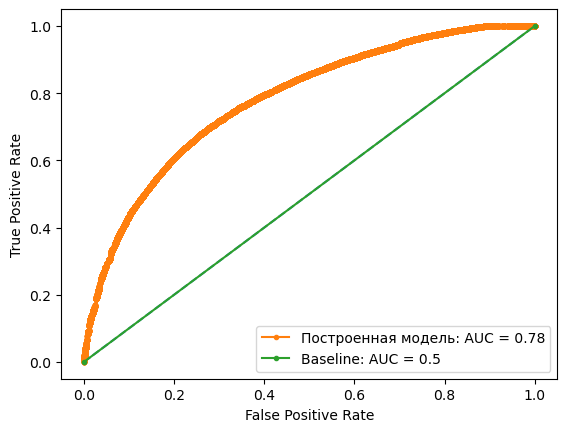

In [13]:
# Запуск тестирования построенной модели
test_model(best_model, X_test, y_test)

Качество полученной модели выше, чем у бейзлайна по показателям log-loss и auc.